# <b>Customer Segmentation Using RFM Analysis</b>

<b>RFM Analysis</b> is a method mainly used in marketing, which uses three factors to segment customers in groups with similar purchasing behaviors. <br>
RFM stands for <b>Recency</b>, <b>Frequency</b> and <b>Monetary value</b>, where:
<ul>
    <li><b>Recency (R):</b> how recently a customer made a purchase or visited our website?.</li>
    <li><b>Frequency (F):</b> how many often do they make purchase?.</li>
    <li><b>Monetary value (M):</b> how much income we receive from the purchases they make?.</li>
</ul>


In [1]:
# Importing libraries 
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn  as sns
%matplotlib inline

In [2]:
# Visualization style
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [3]:
# DATA PATH
DATA_PATH = os.path.join("..","datasets","raw","Online Retail.xlsx")

In [4]:
# Importing dataset
data = pd.read_excel(DATA_PATH)

In [5]:
# Data sample
data.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
341006,566730,21844,RED RETROSPOT MUG,1,2011-09-14 13:31:00,2.95,14606.0,United Kingdom
486168,577711,22435,SET OF 9 HEART SHAPED BALLOONS,2,2011-11-21 12:17:00,1.25,15527.0,United Kingdom
97820,544657,22788,BROCANTE COAT RACK,3,2011-02-22 13:08:00,9.95,14895.0,United Kingdom
462203,575966,23355,HOT WATER BOTTLE KEEP CALM,6,2011-11-13 12:38:00,4.95,13984.0,United Kingdom
513462,579555,22571,ROCKING HORSE RED CHRISTMAS,4,2011-11-30 11:08:00,0.85,16241.0,United Kingdom


In [6]:
data.shape

(541909, 8)

In [7]:
data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [8]:
# Data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [9]:
# Data description
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [10]:
print('='*64)
print('The data corresponds from {} to {}'.format(data.InvoiceDate.min(),
                                             data.InvoiceDate.max()))
print('='*64)

The data corresponds from 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [11]:
# Drop instances where 'CustomerID' is null value
data = data.dropna(subset=['CustomerID'], axis=0)

# Transform 'CustomerID' to int type
data['CustomerID'] =  data['CustomerID'].astype('int')

# Calculate total sale 
data['Sales'] = round(data.UnitPrice * data.Quantity, 2)

# Extract date - no time
data['InvoiceDate'] = data['InvoiceDate'].dt.date

## RFM Features

In [12]:
# CREATING RFM FEATURES
# =============================================================================================

snapshot_date = data.InvoiceDate.max() + dt.timedelta(days=1)

# Aggregate data on a customer level
datamart = data.groupby('CustomerID').agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
                                          'InvoiceNo': 'count',
                                          'Sales': 'sum'})

# Rename columns
datamart.rename(columns={'InvoiceDate': 'Recency',
                        'InvoiceNo': 'Frequency',
                        'Sales': 'MonetaryValue'}, inplace=True)

datamart.sample(5)

,Recency,Frequency,MonetaryValue
CustomerID,,,
12885,64,72,1158.27
15237,2,99,1412.32
13865,59,30,501.56
13452,260,2,590.00
15919,20,143,639.89


### Export RFM Dataset

In [13]:
datamart.to_csv('../datasets/processed/rfm_dataset.csv')

### RFM segments and scores

In [14]:
# Recency quartiles
r_quartiles = pd.qcut(datamart.Recency, 4, labels=range(4, 0, -1))
datamart = datamart.assign(R = r_quartiles.values)

# Frequency quartiles
f_quartiles = pd.qcut(datamart.Frequency, 4, labels=range(1, 5))
datamart = datamart.assign(F = f_quartiles.values)

# Monetary value quartiles
m_quartiles = pd.qcut(datamart.MonetaryValue, 4, labels=range(1, 5))
datamart = datamart.assign(M = m_quartiles.values)

# Building RFM segments
def rfm_seg(x):
    return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))

# Create segment label
datamart['RFM_Segment'] = datamart.apply(rfm_seg, axis=1)

# RFM Score - Sum of scores
datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis=1)

datamart.sample(10)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
16634,223,9,217.90,1,1,1,111,3
13130,95,2,64.00,2,1,1,211,4
15412,172,10,190.53,1,1,1,111,3
15033,5,513,2571.02,4,4,4,444,12
12522,40,12,192.72,3,1,1,311,5
13153,6,15,486.22,4,1,2,412,7
15369,145,1,-1592.49,1,1,1,111,3
14859,13,59,1352.04,4,3,3,433,10
14593,22,152,617.99,3,4,2,342,9


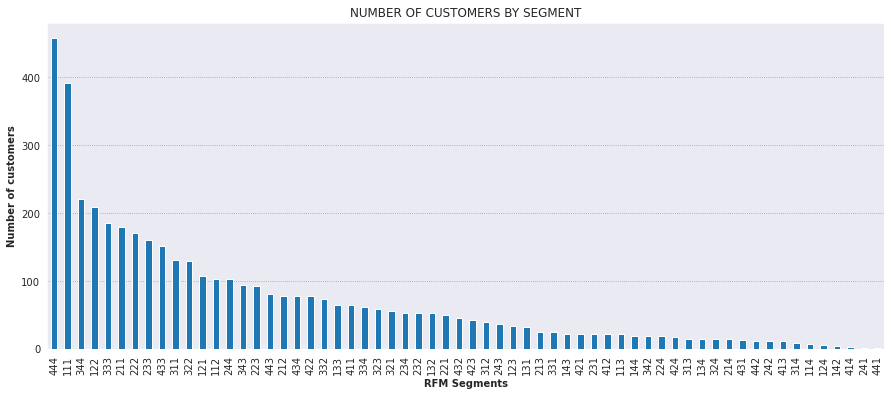

In [15]:
# Number of customers by RFM Segment
segments = datamart['RFM_Segment'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(15,6))
plt.title('NUMBER OF CUSTOMERS BY SEGMENT')
segments.plot(kind='bar')
plt.xlabel('RFM Segments', fontweight='bold')
plt.ylabel('Number of customers', fontweight='bold')
plt.grid(axis='x')
plt.show()

In [16]:
# Data by RFM score
datamart.groupby('RFM_Score').agg({'Recency': 'mean',
                                  'Frequency': 'mean',
                                  'MonetaryValue': 'mean'}).round(1)

,Recency,Frequency,MonetaryValue
RFM_Score,,,
3,265.6,7.8,109.1
4,175.6,13.9,227.0
5,152.7,21.1,343.8
6,95.1,28.6,491.7
7,79.5,39.5,725.4
8,63.0,57.1,972.3
9,44.7,78.8,1361.9
10,32.0,115.3,1897.6
11,21.1,199.9,3993.5


## Customers Segment Labeling

In [17]:
# Labeling segments
def segment_label(df):
    if df['RFM_Score'] >= 9:
        return 'Gold'
    elif (df['RFM_Score'] >= 6) and (df['RFM_Score'] < 9):
        return 'Silver'
    else:
        return 'Bronze'
    
# Assigning segment labels    
datamart['SegmentLabel'] = datamart.apply(segment_label, axis=1)

datamart.sample(10)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,SegmentLabel
CustomerID,,,,,,,,,
13989,66,41,1266.08,2,2,3,223,7,Silver
17049,3,322,5594.78,4,4,4,444,12,Gold
14139,47,26,415.82,3,2,2,322,7,Silver
13355,123,32,674.70,2,2,3,223,7,Silver
16000,3,9,12393.70,4,1,4,414,9,Gold
13986,18,13,320.46,3,1,2,312,6,Silver
12642,26,47,1013.26,3,3,3,333,9,Gold
15850,20,97,238.85,3,3,1,331,7,Silver
16509,297,13,363.70,1,1,2,112,4,Bronze


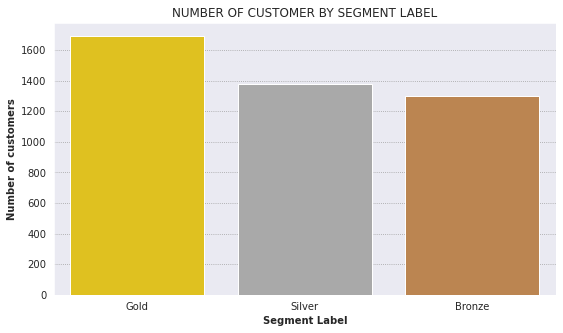

In [18]:
# Visualization of number of customers by segment label
plt.figure(figsize=(9,5))
plt.title('NUMBER OF CUSTOMER BY SEGMENT LABEL')
sns.countplot(x=datamart.SegmentLabel, order=['Gold','Silver','Bronze'], palette=['gold','darkgrey','peru'])
plt.xlabel('Segment Label', fontweight='bold')
plt.ylabel('Number of customers',fontweight='bold')
plt.show()

In [19]:
datamart.groupby('SegmentLabel').mean()

,Recency,Frequency,MonetaryValue,RFM_Score
SegmentLabel,,,,
Bronze,193.511914,14.951576,238.276764,4.099154
Gold,25.889480,194.922577,4127.427163,10.518322
Silver,79.188542,41.746193,729.848426,7.000000
